#TxMM Project: A NLP approach to Becoming Instafamous
s4603478

Radboud University, Nijmegen, the Netherlands

In [1]:
!pip install emosent-py

  Created wheel for emosent-py: filename=emosent_py-0.1.6-cp36-none-any.whl size=28503 sha256=be9d3fd17b8f6c00746abccf27b92d4d91b0322696d9beab8f4dfaf873388a39
  Stored in directory: /root/.cache/pip/wheels/46/32/3c/2e21c3622b77cdc89a38a711240588ac3cf9b8e805eed0f6e1
Successfully built emosent-py


In [22]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from numpy import mean, std
import re
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import codecs
from string import punctuation
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import spearmanr, ttest_ind, pearsonr
from scipy.stats.distributions import norm
import functools
import math
from emosent import get_emoji_sentiment_rank

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Scraping Instagram Data

The *generate_data()* function sends a request for all accounts in the file **account_link.xlsx** by using the package 'Instagramy'. Once the account is scraped, the 12 most recent posts are requested as well and added to the **all_data.xlsx** file. With this the following is saved:


*   Account name
*   Number of followers
*   Number of accounts following
*   Total amount of posts
*   Post URL
*   Post caption/description
*   Post type (video or image)
*   Number of likes
*   Number of comments

In [ ]:
# Not necessary to execute anymore, data is already in data/data.xlsx
def generate_data():
    df_accounts = pd.read_excel("data/account_link.xlsx")
    for row in df_accounts['account_link']:
        account_name = row.split(".com/", 1)[1].split("/", 1)[0]
        user = InstagramUser(account_name)
        followers = user.number_of_followers
        following = user.number_of_followings
        total_posts = user.number_of_posts
        posts = user.posts
        for post in posts:
            print(account_name + ": post-" + str(posts.index(post)))
            df_data = pd.read_excel("data/all_data.xlsx")
            post_url = post['post_url']
            if post['is_video']:
                post_type = "Video"
            else:
                post_type = "Image"
            post_code = post_url.split(".com/p/", 1)[1].split("/", 1)[0]
            ps = InstagramPost(post_code)
            description = ps.caption
            likes = ps.number_of_likes
            comments = ps.number_of_comments
            data_row = {'account_name': account_name, 'followers': followers, 'following': following, 'amount_of_posts': total_posts, 'message_link': post_url, 'message': description, 'message_type': post_type, 'n_likes': likes, 'n_comments': comments, 'n_hashtags': "", 'sentiment.py': ""}
            df_data = df_data.append(data_row, ignore_index=True)
            df_data.to_excel("data/all_data.xlsx", index=False)

Select 500 posts for training

In [ ]:
#df = pd.read_excel("data/all_data.xlsx")
#new_df = df.sample(n=500)

#new_df.to_excel("data/labelled_data.xlsx")

##Supervised Sentiment Analysis

To start of a classifier was trained one 400 labelled posts. Preprocessing consisted of computing the emoji sentiment in the message, cleaning the text, remove all POS tags that are not relevant for the content of the message, and converting the text to a vector with TF-IDF.

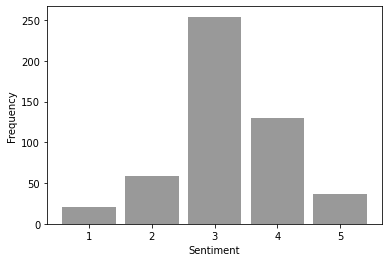

In [7]:
df = pd.read_excel("data/labelled_data.xlsx", index_col=0)

plt.hist(df['sentiment'], bins=5, range=(0.5, 5.5), color='#6E6E6E', alpha=0.7, rwidth=0.85)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

###Computation of the emoji sentiment

In [8]:
def emoji_sentiment_gen(df, filename):
  # Unicodes for emojis
  emoji_unicodes = '[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF]'
  reg = re.compile(r'({})|[^a-zA-Z]'.format(emoji_unicodes))

  # Hex codes for possible skin colors
  emoji_skin_colors = ['\\xf0\\x9f\\x8f\\xba', '\\xf0\\x9f\\x8f\\xbb', '\\xf0\\x9f\\x8f\\xbc', '\\xf0\\x9f\\x8f\\xbd', '\\xf0\\x9f\\x8f\\xbe', '\\xf0\\x9f\\x8f\\xbf']

  for i in range(0, len(df)):
    message = str(df['message'].iloc[i])

    # Find all emojis in a post caption
    emoji_array = reg.findall(message)
    emoji_array = list(filter(None, emoji_array))

    for emoji in emoji_array: 
      emoji_hex = str(emoji.encode('utf-8'))
      emoji_hex = re.sub(r'^b', '', emoji_hex)
      emoji_hex = re.sub("'", '', emoji_hex)

      # Remove unknown '?' caused by the skin color of the emoji
      if emoji_hex in emoji_skin_colors:
        emoji_array.remove(emoji)

    emojis_sentiment = 0
    for emoji in emoji_array:
      try:
        emojis_sentiment = emojis_sentiment + get_emoji_sentiment_rank(emoji)['sentiment_score']
      except:
        emojis_sentiment = emojis_sentiment
    
    df['emoji_sentiment'].iloc[i] = emojis_sentiment
  df.to_excel(filename)

emoji_sentiment_gen(df, "data/labelled_data.xlsx")

In [9]:
df = pd.read_excel("data/labelled_data.xlsx", index_col=0)

messages = df['message'].values
emoji_sentiment = df['emoji_sentiment'].values
labels = df['sentiment'].values

###Clean the data

In [10]:
def clean_data(data):

  cleaned_features = []

  for sentence in range(0, len(data)):
    # Remove hashtags, mentions and urls
    feature = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", str(data[sentence]))

    # Remove non word characters
    feature = re.sub(r'\W+', ' ', feature)

    # Remove all single characters
    feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', feature)

    # Remove single characters from the start
    feature = re.sub(r'\^[a-zA-Z]\s+', ' ', feature) 

    # Substituting multiple spaces with single space
    feature = re.sub(r'\s+', ' ', feature, flags=re.I)

    # Remove all single characters again
    feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', feature)

    # Removing prefixed 'b'
    feature = re.sub(r'^b\s+', '', feature)

    # Converting to Lowercase
    feature = feature.lower()

    cleaned_features.append(feature)

  return cleaned_features

###Remove 'meaningless' words

In [11]:
cleaned_messages = clean_data(messages)

def pos_tags_filter(cleaned_messages):
  # List of POS tags that are not relevant for sentiment analysis
  delete_tags_list = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'LS', 'MD', 'PDT', 'PRP', 'PRP$', 'TO', 'UH', 'VBP', 'WDT', 'WP$', 'WRB']
  new_messages = []
  lemmatizer = WordNetLemmatizer()

  for text in cleaned_messages:
    tokenized_text = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokenized_text)
    new_sentence = ''
    # Check if the POS tag of a word is 'not wanted' if so do not add the word to the renewed message
    for word in pos_tags:
      if word[1] not in delete_tags_list:
        new_sentence = new_sentence + lemmatizer.lemmatize(word[0]) + ' '
    new_messages.append(new_sentence)
  
  return new_messages

new_messages = pos_tags_filter(cleaned_messages)

###Configure data

In [12]:
# Translate raw data to a vector
tf_idf = TfidfVectorizer(max_features=200, min_df=8, max_df=0.7, stop_words=stopwords.words('english'))
fit = tf_idf.fit(new_messages)
voc = tf_idf.get_feature_names()
num_features = tf_idf.transform(new_messages).toarray()

df1 = pd.DataFrame(num_features)
df2 = df['emoji_sentiment']

new_df = pd.concat([df1, df2], axis=1)

###With stratify make sure that all classes are divided equally over the test and train set.

In [13]:
# Get the unique labels with its frequency
def get_class_counts(df):
  (value, freq) = np.unique(df, return_counts=True)
  return value, freq

# Calculate the proportions
def get_class_proportions(df):
  value, freq = get_class_counts(df)
  dic = {}
  for i in range(0,len(value)):
    dic[value[i]] = round(freq[i]/len(df), 4)

  return dic

In [14]:
X_train, X_test, y_train, y_test = train_test_split(new_df, labels, test_size=0.2, random_state=0, stratify=labels)

# Check if the proportions are equal
train_proportions = get_class_proportions(y_train)
test_proportions = get_class_proportions(y_test)

print(train_proportions)
print(test_proportions)

{1: 0.0425, 2: 0.1175, 3: 0.5075, 4: 0.26, 5: 0.0725}
{1: 0.04, 2: 0.12, 3: 0.51, 4: 0.26, 5: 0.07}


###Random Forest

In [15]:
rf_classifier = RandomForestClassifier(max_samples=0.7, n_estimators=350, min_samples_split=5)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.7,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
y_pred_rf = rf_classifier.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred_rf, digits=3))
print("Random Forest accuracy: %s" % accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1      0.000     0.000     0.000         4
           2      0.800     0.333     0.471        12
           3      0.634     0.882     0.738        51
           4      0.522     0.462     0.490        26
           5      1.000     0.143     0.250         7

    accuracy                          0.620       100
   macro avg      0.591     0.364     0.390       100
weighted avg      0.625     0.620     0.578       100

Random Forest accuracy: 0.62


###Prediction of remainder of the data

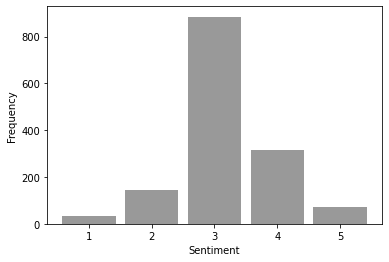

Median supervised sentiment: 3.0


In [25]:
classifier = RandomForestClassifier(n_estimators=200, random_state=0)
classifier.fit(new_df, labels)

data = pd.read_excel("data/data.xlsx", index_col=0)

# Compute emoticon sentiment
emoji_sentiment_gen(data, "data/data.xlsx")

messages_data = data['message'].values
emoji_sentiment_data = data['emoji_sentiment'].values

# Clean the post captions
cleaned_messages_data = clean_data(messages_data)

# Remove words with irrelevant POS tags
new_messages_data = pos_tags_filter(cleaned_messages_data)

# Translate raw text to vector
tf_idf_data = TfidfVectorizer(max_features=200, min_df=8, max_df=0.7, stop_words=stopwords.words('english'), vocabulary=voc)
num_features_data = tf_idf_data.fit_transform(new_messages_data).toarray()
df1_data = pd.DataFrame(num_features_data)
df2_data = data['emoji_sentiment']

new_df_data = pd.concat([df1_data, df2_data], axis=1)
# Predict the sentiment
pred_sentiments = classifier.predict(new_df_data)
data['supervised_sentiment'] = pred_sentiments

plt.hist(data['supervised_sentiment'], bins=5, range=(0.5, 5.5), color='#6E6E6E', alpha=0.7, rwidth=0.85)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

print("Median supervised sentiment: %s" % data['supervised_sentiment'].median())

data.to_excel("data/data.xlsx")

##Unsupervised Sentiment Analysis

For this the NLTK vader lexicon was used to compute the sentiment for all the data. With this approach the decision was made to leave the emoji because they can influence the sentiment. 

In [26]:
# Using NLTK vader Lexicon to compute the sentiment
sid = SentimentIntensityAnalyzer()
df_all = pd.read_excel("data/data.xlsx", index_col=0)

In [27]:
for row in range(0, len(df_all)):
  message = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", str(df_all['message'].iloc[row]))

  sentiment = sid.polarity_scores(message)['compound']

  df_all['sentiment'].iloc[row] = sentiment
print("Median unsupervised sentiment: %.3f" % df_all['sentiment'].median())
df_all.to_excel("data/data.xlsx")

Median unsupervised sentiment: 0.226


##Feature Extraction for correlation

###Ratio of likes with respect to number of followers

In [28]:
data = pd.read_excel("data/data.xlsx", index_col=0)

for row in range(0, len(data)):
  ratio = data['n_likes'].iloc[row]/data['followers'].iloc[row]
  data['ratio_likes'].iloc[row] = round(ratio, 5)

data.to_excel("data/data.xlsx")

###Number of hashtags

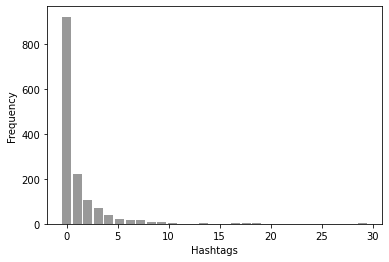

Median hashtags: 0.000
Average hashtags: 1.110


In [29]:
data = pd.read_excel("data/data.xlsx", index_col=0)

for row in range(0, len(data)):
  message = re.sub('#x27', '', str(data['message'].iloc[row]))
  hashtags = re.findall("(#[A-Za-z0-9]+)", message)
  data['n_hashtags'].iloc[row] = len(hashtags)

plt.hist(data['n_hashtags'], bins = 29, range=[-0.5, 29.5], color='#6E6E6E', alpha=0.7, rwidth=0.85)
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.show()

print("Median hashtags: %.3f" % data['n_hashtags'].median())
print("Average hashtags: %.3f" % data['n_hashtags'].mean())

data.to_excel("data/data.xlsx")

###Number of mentions

In [30]:
data_men = pd.read_excel("data/data.xlsx", index_col=0)

for row in range(0, len(data_men)):
  mentions = re.findall("(@[A-Za-z0-9]+)", str(data_men['message'].iloc[row]))
  data_men['n_mentions'].iloc[row] = len(mentions)

data_men.to_excel("data/data.xlsx")

##Analysis

Number of images is 994 and number of videos is 453
Median number of followers: 46252972.0
Median number of likes: 1024721.0


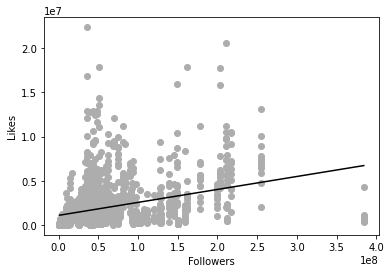

Correlation of 0.327 between followers and likes with a p-value of 0.000


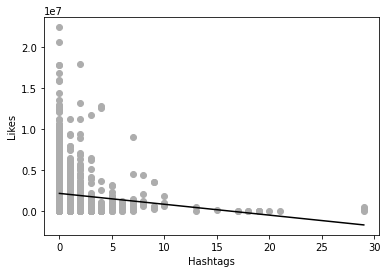

Correlation of -0.134 between likes ratio and hashtags with a p-value of 0.000
Correlation of -0.004 between likes ratio and supervised sentiment with a p-value of 0.890
Correlation of -0.048 between likes ratio and unsupervised sentiment with a p-value of 0.067


In [32]:
data = pd.read_excel("data/data.xlsx", index_col=0)

# Print general information
print('Number of images is %s and number of videos is %s' % (len(data[data['message_type'] == 'Image']), len(data[data['message_type'] == 'Video'])))
print("Median number of followers: %s" % data['followers'].median())
print("Median number of likes: %s" % data['n_likes'].median())

# Correlation between followers and likes
plt.scatter(data['followers'], data['n_likes'], color='#adadad')
plt.xlabel('Followers')
plt.ylabel('Likes')
plt.plot(np.unique(data['followers']), np.poly1d(np.polyfit(data['followers'], data['n_likes'], 1))(np.unique(data['followers'])), color='#000000')
plt.show()

print("Correlation of %.3f between followers and likes with a p-value of %.3f" % (pearsonr(data['n_likes'], data['followers'])[0], pearsonr(data['n_likes'], data['followers'])[1]))

# Correlation between hashtags and likes
plt.scatter(data['n_hashtags'], data['n_likes'], color='#adadad')
plt.xlabel('Hashtags')
plt.ylabel('Likes')
plt.plot(np.unique(data['n_hashtags']), np.poly1d(np.polyfit(data['n_hashtags'], data['n_likes'], 1))(np.unique(data['n_hashtags'])), color='#000000')
plt.show()

print("Correlation of %.3f between likes ratio and hashtags with a p-value of %.3f" % (pearsonr(data['n_hashtags'], data['n_likes'])[0], pearsonr(data['n_hashtags'], data['n_likes'])[1]))

# Correlation between sentiment and likes
print("Correlation of %.3f between likes ratio and supervised sentiment with a p-value of %.3f" % (pearsonr(data['supervised_sentiment'], data['n_likes'])[0], pearsonr(data['supervised_sentiment'], data['n_likes'])[1]))
print("Correlation of %.3f between likes ratio and unsupervised sentiment with a p-value of %.3f" % (pearsonr(data['n_likes'], data['sentiment'])[0], pearsonr(data['n_likes'], data['sentiment'])[1]))
